# Projekt MSP1 / 2024
Cílem tohoto projektu je se seznámit s programovými nástroji využívaných ve statistice a osvojit si základní procedury. Projekt není primárně zaměřen na efektivitu využívání programového vybavení (i když úplně nevhodné konstrukce mohou mít vliv na hodnocení), ale nejvíce nás zajímají vaše statistické závěry a způsob vyhodnocení. Dbejte také na to, že každý graf musí splňovat nějaké podmínky - přehlednost, čitelnost, popisky.

V projektu budete analyzovat časy běhu šesti různých konfigurací algoritmů. Ke každé konfiguraci vzniklo celkem 200 nezávislých běhů, jejichž logy máte k dispozici v souboru [logfiles.zip](logfiles.zip).

Pokud nemáte rozchozené prostředí pro pro spouštění Jupyter notebooku, můžete využití službu [Google Colab](https://colab.google/). Jakákoliv spolupráce, sdílení řešení a podobně je zakázána!

S případnými dotazy se obracejte na Vojtěcha Mrázka (mrazek@fit.vutbr.cz).

__Odevzdání:__ tento soubor (není potřeba aby obsahoval výstupy skriptů) do neděle 27. 10. 2024 v IS VUT. Kontrola bude probíhat na Pythonu 3.12.3 (standardní instalace Ubuntu); neočekává se však to, že byste používali nějaké speciality a nekompatibilní knihovny. V případě nesouladu verzí a podobných problémů budete mít možnost reklamace a prokázání správnosti funkce. Bez vyplnění vašich komentářů a závěrů do označených buněk nebude projekt hodnocen!

__Upozornění:__ nepřidávejte do notebooku další buňky, odpovídejte tam, kam se ptáme (textové komentáře do Markdown buněk)

__Tip:__ před odevzdáním resetujte celý notebook a zkuste jej spustit od začátku. Zamezíte tak chybám krokování a editací, kdy výsledek z buňky na konci použijete na začátku.

__OTÁZKA K DOPLNĚNÍ:__

_Jméno a login autora_

Ondřej Koumar, xkouma02

## Načtení potřebných knihoven
Načtěte knihovny, které jsou nutné pro zpracování souborů a práci se statistickými funkcemi.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import json
from zipfile import ZipFile

## Načtení dat do DataFrame
Ze souboru `logfiles.zip` umístěném ve stejném adresáři načtěte data a vytvořte Pandas DataFrame.

Výsledky jsou uložené ve formátu JSON - pro zpracování použijte knihovnu `json`.
Můžete využít následující kostru - je vhodné pracovat přímo se ZIP souborem. Jedinou nevýhodou může být to, že vám bude vracet _byte_ objekt, který musíte přes funkci `decode` zpracovat.

Upravte také pomocí funkce `.astype()` datové typy patřičných sloupců.

```py
data = []
with ZipFile("logfiles.zip") as zf:
    for filename in zf.namelist():
        # TODO test názvu souboru
        with zf.open(filename, "r") as f:
            pass # vytvořte slovník

df = pd.DataFrame(data)
df
```

In [2]:
data = []
with ZipFile("logfiles.zip") as zf:
    for filename in zf.namelist()[1:]:
        with zf.open(filename, "r") as f:
            json_text = f.read().decode("utf-8")
            json_data = json.loads(json_text)
            data.append(json_data)

df = pd.DataFrame(data) 

## Analýza a čištění dat
Vhodným způsobem pro všechny konfigurace analyzujte časy běhů a pokud tam jsou, identifikujte hodnoty, které jsou chybné. Vyberte vhodný graf, který zobrazí samostatně jednotlivé konfigurace.

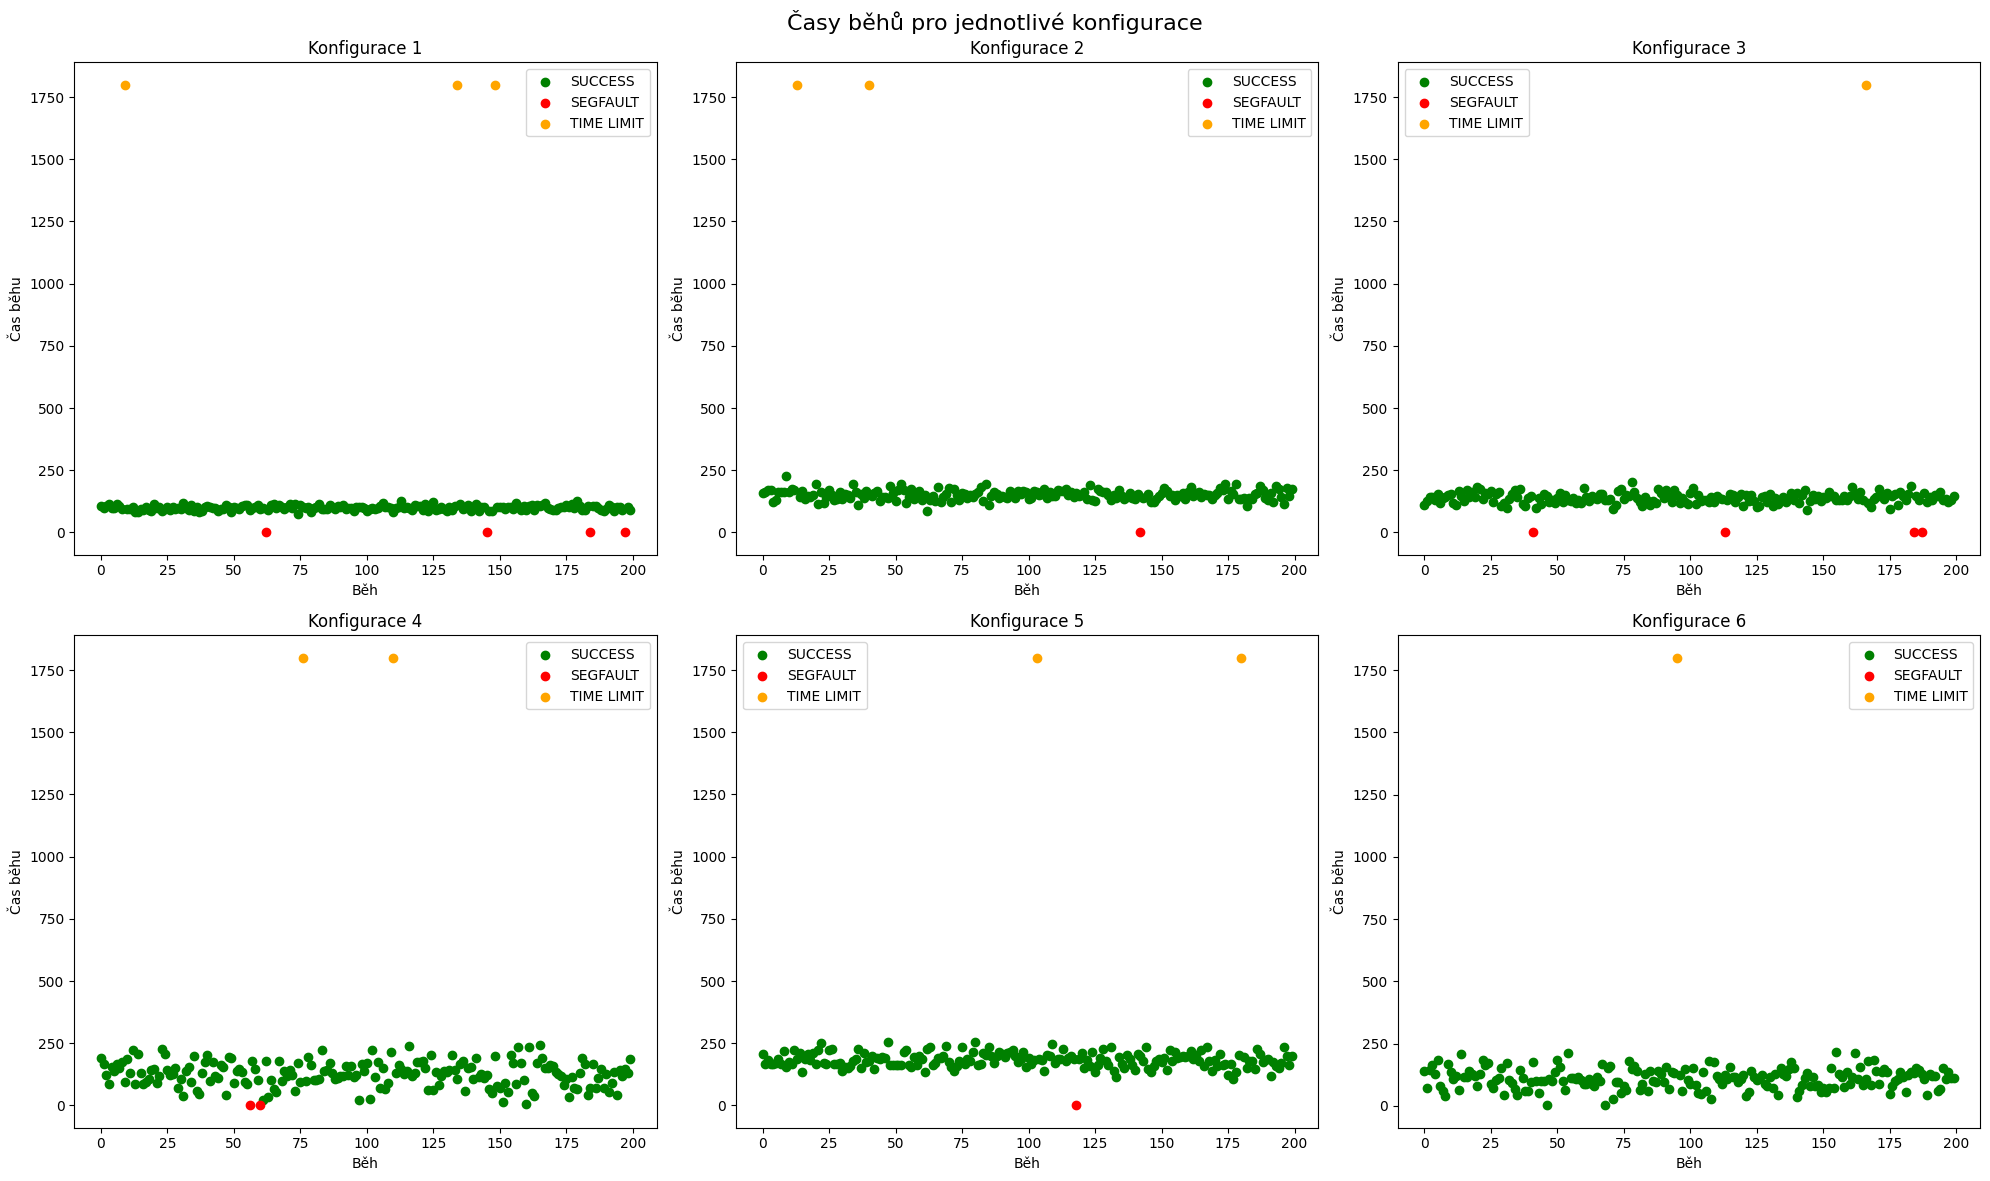

In [3]:
# With the commented code below, I found types of faults and their indices
# faults = {}
# for index, data in enumerate(df["status"]):
#     if data != "SUCCESS":
#         faults[f"{index}"] = data

df = df.astype({"status": "category","runtime": "double", "run": "int32"})
df["configuration"] = df["configuration"].str.extract(r"(\d+)").astype("int32")

status_colours = {"SUCCESS": "green", "SEGFAULT": "red", "TIME LIMIT": "orange"}
df["status_colour"] = df["status"].map(status_colours).astype("category")

fig = plt.figure(figsize=(20, 12), tight_layout=True)
fig.suptitle("Časy běhů pro jednotlivé konfigurace", fontsize=16)
axes = fig.subplots(2, 3).ravel()

for i in range(6):
    ax = axes[i]
    # Select configuration
    df_config = df.loc[df["configuration"] == i + 1]

    for status, colour in status_colours.items():
        # Select only rows with the given status
        df_status = df_config[df_config["status"] == status]

        # Plot data with the given status
        ax.scatter(df_status["run"], df_status["runtime"], c=colour, label=status)

    ax.set_title(f"Konfigurace {i + 1}")
    ax.set_xlabel("Běh")
    ax.set_ylabel("Čas běhu")
    ax.legend()

__OTÁZKA K DOPLNĚNÍ:__

_Objevily se nějaké chybné hodnoty? Proč tam jsou s ohledem na to, že se jedná o běhy algoritmů? Proč jste zvolili tento typ grafu?_

Objevily, několikrát SEGFAULT a několikrát TIME LIMIT. Předpokládám, že buď algoritmy samotné jsou chybně implementované, případně data na vstupu těchto algoritmů byla chybná. Než jsem vůbec začal dělat grafy, podíval jsem se, jaké jsou tam typy chyb a kolik jich je. Schválně jsem zvolil scatter plot a různé barvičky pro různý status, aby hodně vynikly rozdíly mezi normálními a chybnými běhy algoritmů. Pro vyčištěný dataframe použiji boxplot, který lépe ukáže rozložení hodnot časů nechybných běhů, navíc se všechno pěkně vleze do jednoho grafu.


Vyčistěte dataframe `df` tak, aby tam tyto hodnoty nebyly a ukažte znovu analýzu toho, že čištění dat bylo úspěšné. Odtud dále pracujte s vyčištěným datasetem.

In [4]:
df = df.loc[df["status"] == "SUCCESS"]

# Won't need status and it's colour anymore
df = df.drop(columns=["status", "status_colour"])

## Deskriptivní popis hodnot
Vypište pro jednotlivé konfigurace základní deskriptivní parametry.  

__TIP__ pokud výsledky uložíte jako Pandas DataFrame, zobrazí se v tabulce.

In [5]:
descriptive_df = df.groupby("configuration").agg(
    {"runtime": ["mean", "std", "var"]}
)
descriptive_df

runtime                        
                     mean        std          var
configuration                                    
1               99.590413   9.386788    88.111791
2              151.732975  19.833198   393.355739
3              138.616959  19.867428   394.714708
4              127.606156  50.282164  2528.295979
5              183.659767  28.729836   825.403473
6              110.422689  40.875754  1670.827284

__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte, co všechno můžeme z parametrů vyčíst._

## Vizualizace
Vizualizujte časy běhů algoritmů tak, aby byl v jednom grafu zřejmý i rozptyl hodnot, avšak bylo možné porovnání. Zvolte vhodný graf, který pak níže komentujte.

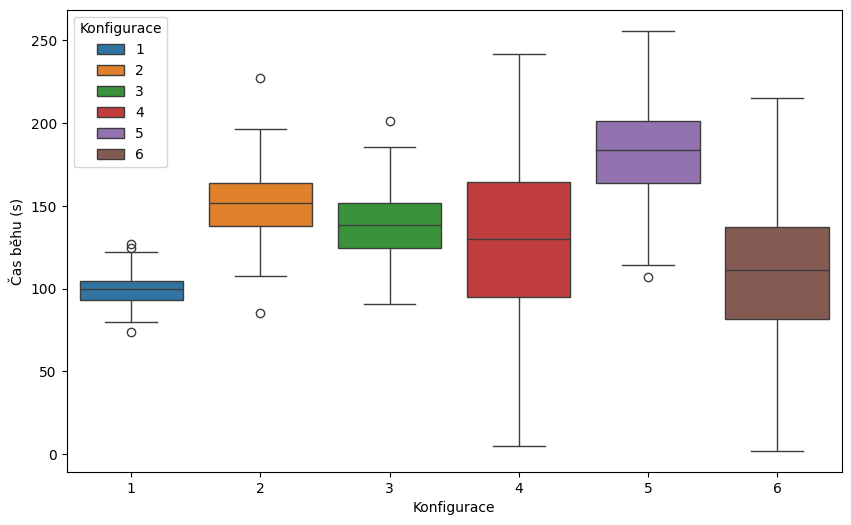

In [6]:
palette = sns.color_palette("tab10", 6)
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.boxplot(data=df, x="configuration", y="runtime", hue="configuration", palette=palette)
ax.set_xlabel("Konfigurace")
ax.set_ylabel("Čas běhu (s)")
ax.legend(title="Konfigurace")
plt.show()

__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte  výsledky z tabulky._

V grafu lze vidět, že o konfiguracích 2, 3, 5 můžeme prohlásit, že nejsou optimální pro řešení daného problému, protože jejich časy sice vypadají relativně stabilně, nicméně nejsou efektivní proti ostatním. Konfigurace 4 a 6 mají velké rozptyly, ale ve spoustě případů jsou časově efektivní, stejně tak ale neefektivní. Konfigurace 4 je o něco horší než konfigurace 6. Na první pohled se zdá, že konfigurace 1 by mohla být nejlepší, protože má velmi stabilní a relativně nízký čas běhu, navíc má nejlepší medián času běhů.

__OTÁZKA K DOPLNĚNÍ:__

_Jaká data budete zkoumat? Jaké mají rozložení a parametry (např. varianci) a jaký test použijete? Jaká je nulová hypotéza? Jak se liší variabilita a poloha vybraných konfigurací?_

Z grafu lze také vyčíst, že data by mohla mít normální rozložení - běhy v 2. a 3. kvartilu mají rozptyl relativně malý a cca mohly by sedět do intervalu (mi - 1sigma, mi + 1sigma). Tím pádem bych použil statistický test středních hodnot normálního rozdělení. Nejvíce se mi líbí nepárový test středních hodnot dvou nezávislých normálních rozdělení, na což by seděl studentův t-test. Protože ale počítá s podobnými rozptyly, které podobné rozhodně nejsou, použiji modifikaci tohoto testu, a to Welshův t-test.

Nulová hypotéza zní, že obě dvě konfigurace jsou stejně rychlé.
Alternativní hypotéza zní, že první konfigurace je rychlejší, protože z grafů rychlostí konfigurací to vypadalo, že by teoreticky mohla být lepší (můj vizuální odhad).

## Určení efektivity konfigurací algoritmů
Nás ale zajímá, jaká konfigurace je nejrychlejší. Z výše vykresleného grafu můžeme vyloučit některé konfigurace. Existuje tam však minimálně jedna dvojice, u které nedokážeme jednoznačně určit, která je lepší - pokud nebudeme porovnávat pouze extrémní hodnoty, které mohou být dané náhodou, ale celkově. Proto proveďte vhodný test významnosti - v následující části diskutujte zejména rozložení dat (i s odkazem na předchozí buňky, variabilitu vs polohu a podobně). Je nutné každý logický krok a výběry statistických funkcí komentovat. 

Vužijte vhodnou funkci z knihovny `scipy.stats` a funkci poté __implementujte sami__ na základě základních matematických funkcí knihovny `numpy` případně i funkcí pro výpočet vybraného rozložení v [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html). Při vlastní implementaci není nutné se primárně soustředit na efektivitu výpočtu (není potřeba využít všechny funkce numpy, můžete použít normální cykly a podobně - v hodnocení však bude zahrnuta přehlednost a neměly by se objevit jasné chyby, jako je zvýšení třídy složitosti a podobně).

In [7]:
res_stats = stats.ttest_ind(df.loc[df["configuration"] == 1, "runtime"],
    df.loc[df["configuration"] == 6, "runtime"], equal_var=False, alternative="less")
print(f"T-stat: {res_stats.statistic:.4f}")
print(f"P-value: {res_stats.pvalue:.4f}")
print(f"df: {res_stats.df:.4f}")

T-stat: -3.6407
P-value: 0.0002
df: 219.4488


__OTÁZKA K DOPLNĚNÍ:__

_Jaký je závěr statistického testu?_

T-statistika je relativně daleko od 0, což znamená, že vstupní konfigurace se dost liší. Navíc je záporné, dá se tedy očekávat, že hodnoty první testované konfigurace jsou nižší než hodnoty druhé testované konfigurace, což zároveň bylo alternativní hypotézou.
P-hodnota je 0.0002, což znamená, že se spolehlivostí 99,9998 % nulovou hypotézu zamítáme, tedy první testovaná konfigurace je rychlejší než druhá testovaná konfigurace.

### Vlastní implementace
Implementujte stejný test pomocí knihovních funkcí a ukažte, že je výsledek stejný.

In [8]:
# source of formulas: https://www.datanovia.com/en/lessons/types-of-t-test/unpaired-t-test/welch-t-test/

mean1 = descriptive_df.loc[1, ("runtime", "mean")]
mean2 = descriptive_df.loc[6, ("runtime", "mean")]
std1 = descriptive_df.loc[1, ("runtime", "std")]
std2 = descriptive_df.loc[6, ("runtime", "std")]
n1 = df.loc[df["configuration"] == 1].shape[0]
n2 = df.loc[df["configuration"] == 6].shape[0]

t_stat = np.round((mean1 - mean2) / np.sqrt(std1**2 / n1 + std2**2 / n2), 4)
deg = np.round((std1**2 / n1 + std2**2 / n2)**2 / (std1**4 / (n1**2 * (n1 - 1)) + std2**4 / (n2**2 * (n2 - 1))), 4)
print(f"Calculated T-stat: {t_stat}, degrees of freedom: {deg}")

Calculated T-stat: -3.6407, degrees of freedom: 219.4488


T-statistika a stupně volnosti vyšly stejně, jako u testu z knihovny Scipy. Hodnota p se pak dá najít tabulkově, respektive použil jsem online kalkulačku na adrese [https://www.omnicalculator.com/statistics/p-value](https://www.omnicalculator.com/statistics/p-value). Zadané parametry: T-stat = -3.6407, df = 219, výsledná p-hodnota je 0.00016966, po zaokrouhlení 0.0002, což je stejné, jako p-hodnota t-testu z knihovny Scipy.

Za přidanou buňku se omlouvám, ale chtěl jsem doplnit informace o p-hodnotě mimo kód.